# `HFSAnomalyModel` Tutorial

Trey V. Wenger (c) August 2024

`HFSAnomalyModel` is like `HFSModel`, but allows for non-LTE variations in hyperfine component optical depths, often called "hyperfine anomalies." This notebook demonstrates this model and is otherwise nearly identical to the `HFSModel` notebook.

In [1]:
# General imports
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

from bayes_cn_hfs import HFSModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.6.3+2.gfe5a862.dirty
bayes_cn_hfs version: 1.0.0-staging+0.g7b9ceed.dirty


## `get_molecule_data`

In [2]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

## Simulating Data

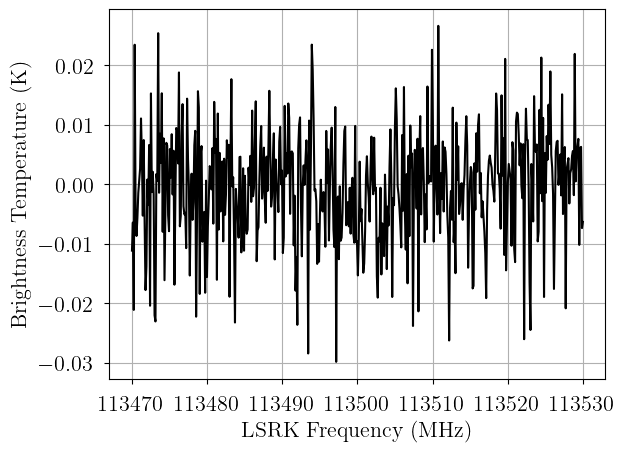

In [3]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.linspace(113470.0, 113530.0, 500) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.01 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

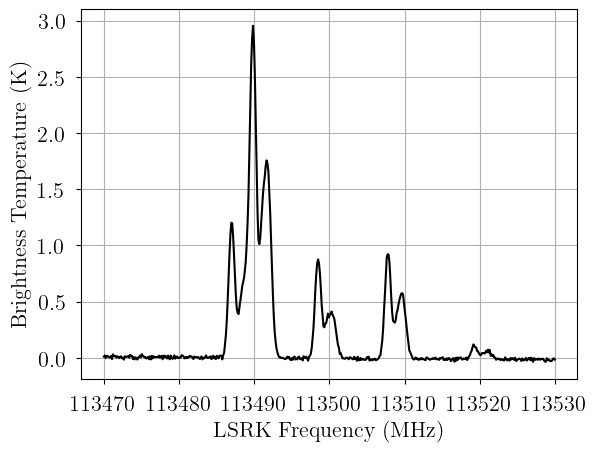

In [4]:
from bayes_cn_hfs import HFSAnomalyModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = HFSAnomalyModel(
    dummy_data,
    mol_data=mol_data_12CN,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [14.0, 0.2], # mean and width of log10(N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_rms = 0.1, # width of spectral rms prior (K)
    prior_tex_anomaly = 1.0, # width of the hyperfine anomaly prior (K)
)
model.add_likelihood()

tex_anomaly = np.ones((len(mol_data_12CN['freq']), n_clouds))
for i, freq in enumerate(mol_data_12CN['freq']):
    if freq == 113499.643:
        tex_anomaly[i] = np.array([-5.0, -4.0, -3.0])
    if freq == 113508.934:
        tex_anomaly[i] = np.array([5.0, 4.0, 3.0])

sim_brightness = model.model.observation.eval({
    "log10_N": [14.0, 13.5, 14.2],
    "log10_tex": [1.0, 1.2, 1.1],
    "fwhm": [3.0, 2.0, 2.5],
    "velocity": [-2.0, 0.0, 3.0],
    "rms_observation": noise,
    "tex_anomaly": tex_anomaly,
    "baseline_observation_norm": [-0.5, -3.0, 2.0], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [5]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model Definition

In [6]:
# Initialize and define the model
model = HFSAnomalyModel(
    data,
    mol_data=mol_data_12CN,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [14.0, 0.2], # mean and width of log10(N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_rms = 0.1, # width of spectral rms prior (K)
    prior_tex_anomaly = 1.0, # width of the hyperfine anomaly prior (K)
)
model.add_likelihood()

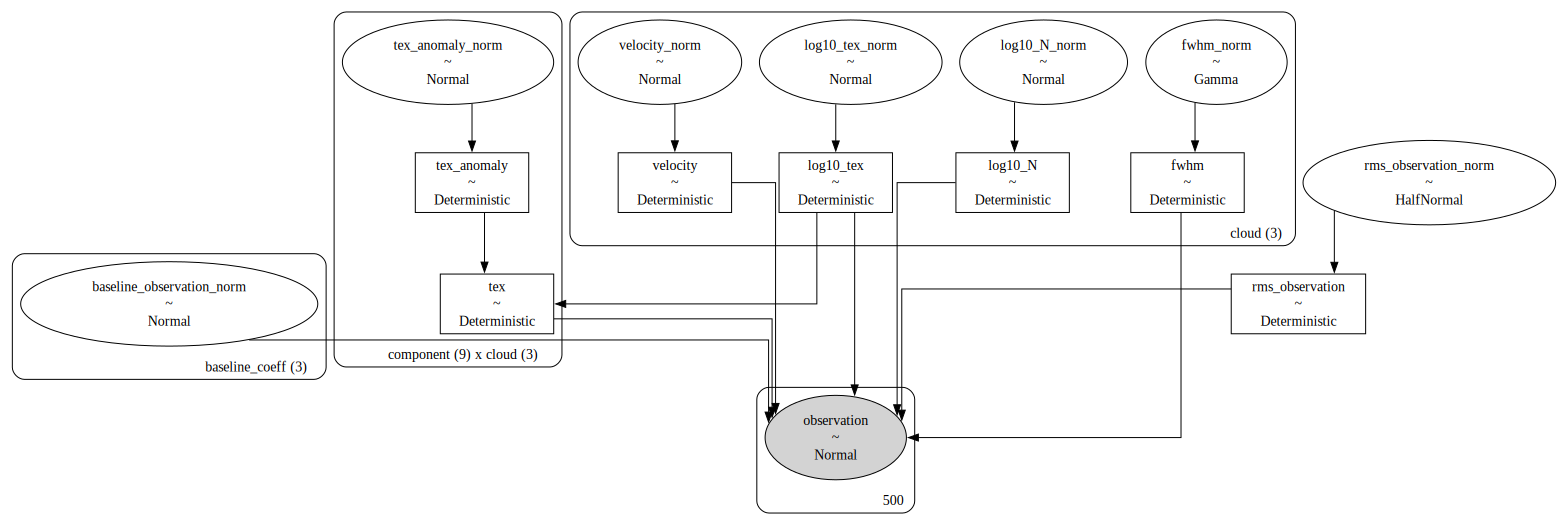

In [7]:
# Plot model graph
model.graph().render('hfs_anomaly_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, <constant>)
             log10_N_norm ~ Normal(0, 1)
           log10_tex_norm ~ Normal(0, 1)
                fwhm_norm ~ Gamma(2, f())
            velocity_norm ~ Normal(0, 1)
     rms_observation_norm ~ HalfNormal(0, 1)
         tex_anomaly_norm ~ Normal(0, 1)
                  log10_N ~ Deterministic(f(log10_N_norm))
                log10_tex ~ Deterministic(f(log10_tex_norm))
                     fwhm ~ Deterministic(f(fwhm_norm))
                 velocity ~ Deterministic(f(velocity_norm))
          rms_observation ~ Deterministic(f(rms_observation_norm))
              tex_anomaly ~ Deterministic(f(tex_anomaly_norm))
                      tex ~ Deterministic(f(tex_anomaly_norm, log10_tex_norm))
              observation ~ Normal(f(baseline_observation_norm, tex_anomaly_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm), rms_observation)


Sampling: [baseline_observation_norm, fwhm_norm, log10_N_norm, log10_tex_norm, observation, rms_observation_norm, tex_anomaly_norm, velocity_norm]


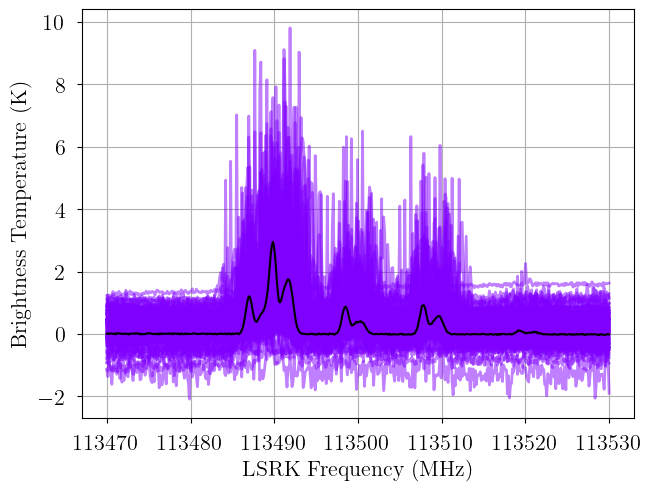

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5500
Interrupted at 5,499 [5%]: Average Loss = -141.92


Runtime: 0.68 minutes


In [11]:
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N[0],13.926,0.002,13.922,13.929,0.000,0.000,1135.0,978.0,NaN
log10_N[1],13.839,0.003,13.834,13.844,0.000,0.000,936.0,786.0,NaN
log10_N[2],14.111,0.001,14.109,14.113,0.000,0.000,926.0,893.0,NaN
log10_tex[0],0.900,0.004,0.892,0.906,0.000,0.000,868.0,875.0,NaN
log10_tex[1],1.097,0.008,1.081,1.111,0.000,0.000,967.0,969.0,NaN
log10_tex[2],0.964,0.011,0.944,0.986,0.000,0.000,915.0,975.0,NaN
fwhm[0],3.088,0.015,3.062,3.116,0.000,0.000,1000.0,981.0,NaN
fwhm[1],4.671,0.040,4.603,4.755,0.001,0.001,1041.0,914.0,NaN
fwhm[2],2.292,0.008,2.279,2.306,0.000,0.000,1063.0,975.0,NaN
velocity[0],-1.979,0.008,-1.994,-1.962,0.000,0.000,908.0,983.0,NaN


Sampling: [observation]


Output()

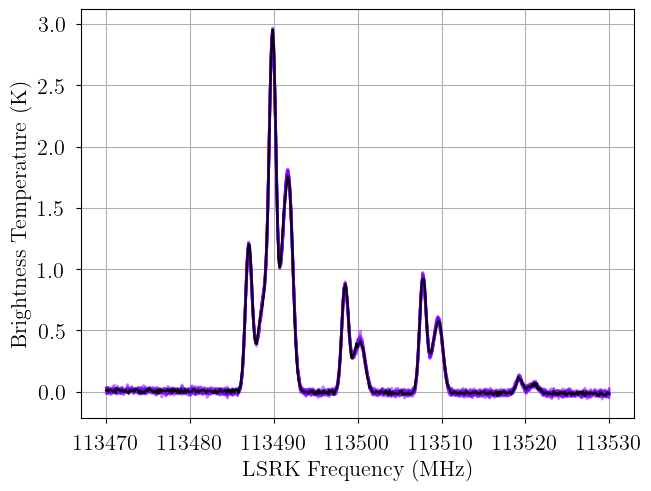

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5500
Interrupted at 5,499 [5%]: Average Loss = -141.92
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm, rms_observation_norm, tex_anomaly_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 938 seconds.


Runtime: 16.62 minutes


In [14]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [15]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"], var_names=model.cloud_deterministics)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N[0],13.996,0.011,13.975,14.017,0.000,0.000,1113.0,1717.0,1.0
log10_N[1],13.476,0.045,13.397,13.566,0.001,0.001,1556.0,2107.0,1.0
log10_N[2],14.175,0.010,14.156,14.194,0.000,0.000,1217.0,1983.0,1.0
log10_tex[0],0.910,0.031,0.850,0.967,0.001,0.001,1174.0,2028.0,1.0
log10_tex[1],1.102,0.088,0.941,1.267,0.002,0.001,2557.0,2444.0,1.0
log10_tex[2],1.004,0.035,0.937,1.067,0.001,0.001,1372.0,2156.0,1.0
fwhm[0],2.988,0.035,2.922,3.051,0.001,0.001,1228.0,1694.0,1.0
fwhm[1],2.058,0.061,1.948,2.175,0.002,0.001,1310.0,2161.0,1.0
fwhm[2],2.457,0.014,2.431,2.482,0.000,0.000,2158.0,2797.0,1.0
velocity[0],-1.988,0.026,-2.037,-1.939,0.001,0.001,1120.0,1508.0,1.0


Sampling: [observation]


Output()

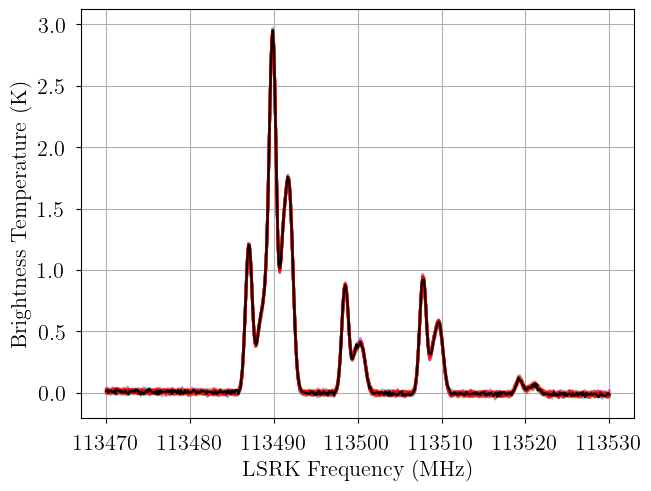

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

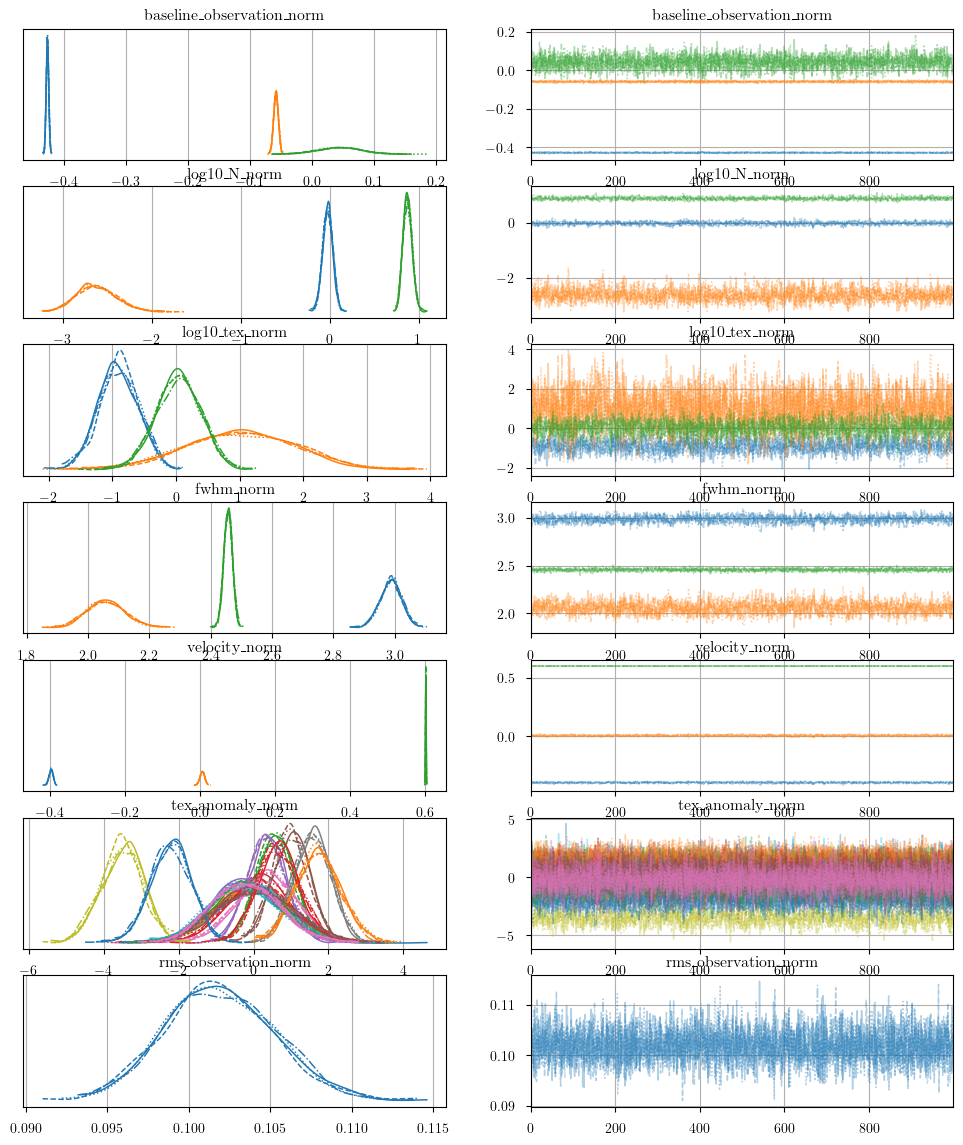

In [17]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.baseline_freeRVs + model.cloud_freeRVs + model.hyper_freeRVs)

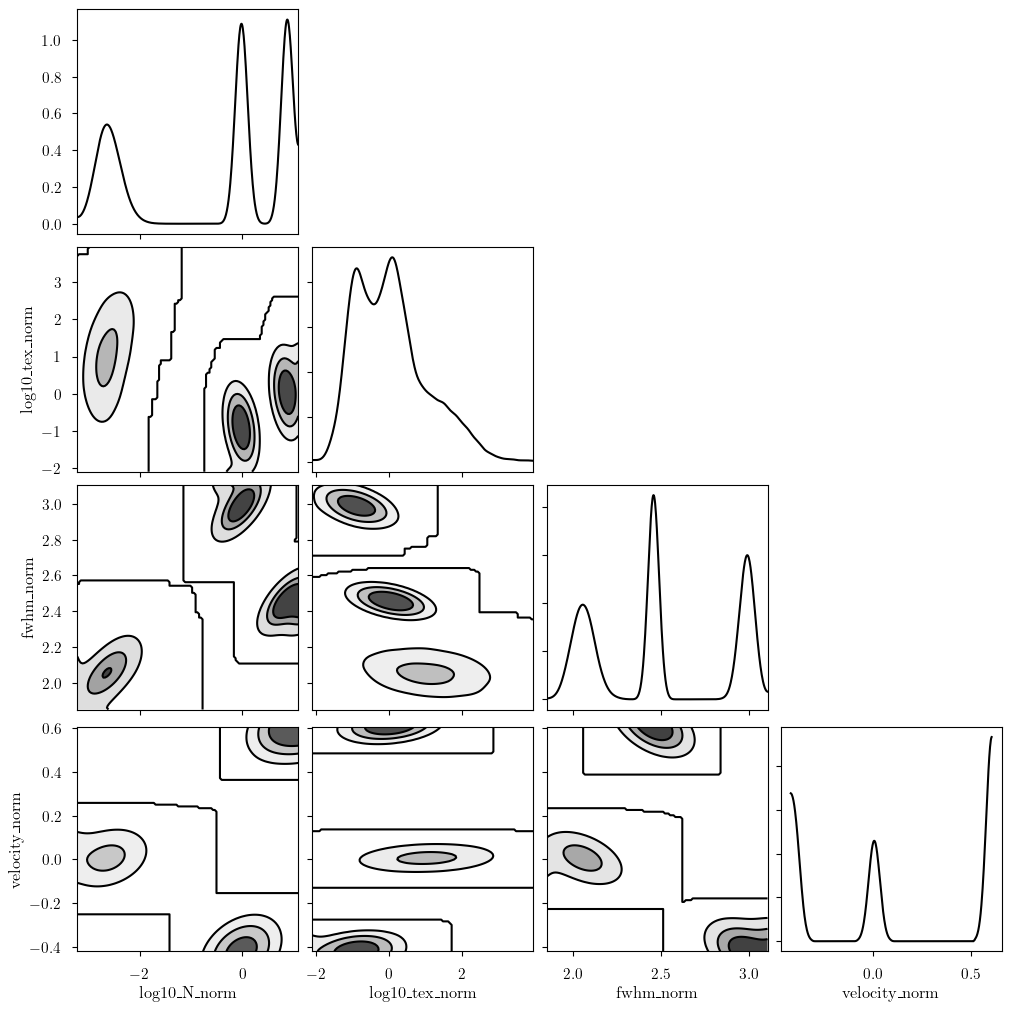

In [21]:
from bayes_spec.plots import plot_pair

var_names = [param for param in model.cloud_freeRVs if "tex_anomaly" not in param]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

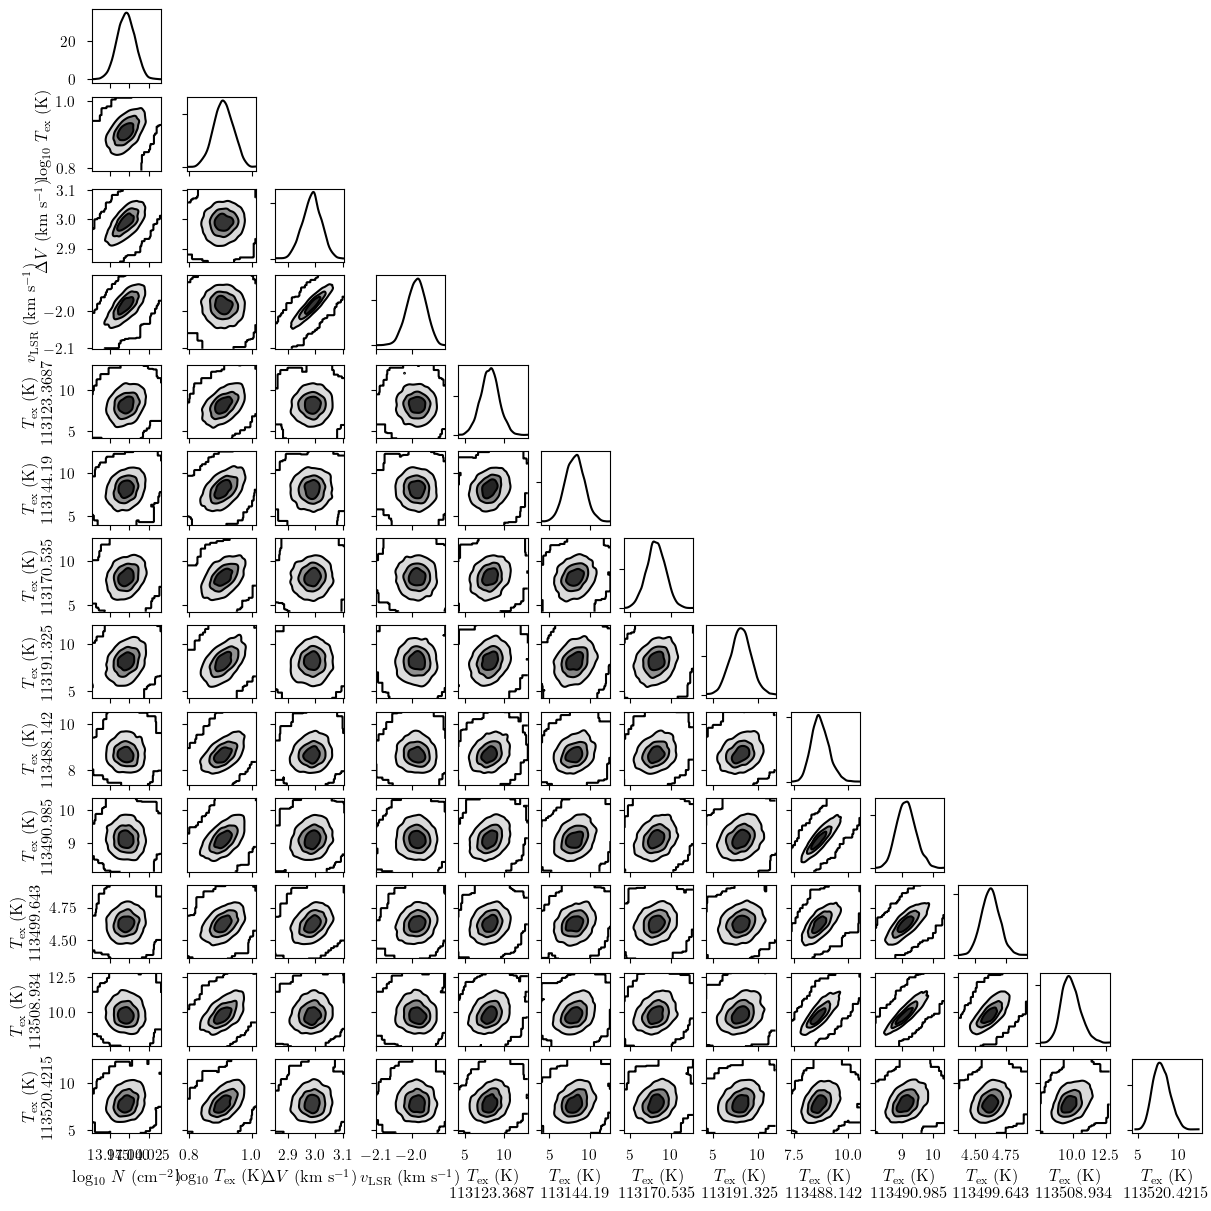

In [24]:
var_names = [param for param in model.cloud_deterministics if "tex_anomaly" not in param]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

In [25]:
point_stats = az.summary(model.trace.solution_0, model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -2798.7041636709964


,mean,sd,hdi_16%,hdi_84%
log10_N[0],13.996,0.011,13.986,14.008
log10_N[1],13.476,0.045,13.426,13.513
log10_N[2],14.175,0.010,14.165,14.185
log10_tex[0],0.910,0.031,0.879,0.941
log10_tex[1],1.102,0.088,1.015,1.190
log10_tex[2],1.004,0.035,0.969,1.039
fwhm[0],2.988,0.035,2.955,3.024
fwhm[1],2.058,0.061,1.998,2.119
fwhm[2],2.457,0.014,2.443,2.470
velocity[0],-1.988,0.026,-2.011,-1.959
